# Frozen Lake Testing

Short notebook just playing around with the Frozen Lake environment to get a feel for it.

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from crl.envs.frozen_lake import make_env
from crl.utils.graphing import get_robust_perf_stats, plot_robust_perf_curve, despine
from crl.predictors.tabular import PredictorGlobal, PredictorSAConditioned, NoPredictor
from crl.agents.tabular import DynaVAgent, AgentParams, Reward
from tqdm import trange

In [141]:
env = make_env(1, slip_prob=0.0)()

In [150]:
ACTION_MAP = {
    'left': 0, 'down': 1, 'right': 2, 'up': 3
}
state, info = env.reset()

In [ ]:
state, reward, terminated, truncated, info = env.step(ACTION_MAP['down'])
state, reward, terminated, truncated, info = env.step(ACTION_MAP['down'])


In [152]:
state, terminated, truncated

(8, False, False)

## Define a tabular agent to solve the env for a fixed map

Using a value-function based Dyna setup

S <- current state\
A <- epsilon-greedy V(s') for all possible actions\
receive S', R\
Model(S, A, S') <- (running average)\
Loop:\
&nbsp;&nbsp;&nbsp;&nbsp;S <- random previously observed state\
&nbsp;&nbsp;&nbsp;&nbsp;A <- random previously taken action\
&nbsp;&nbsp;&nbsp;&nbsp;R, S' <- sample from Model(S, A)\
&nbsp;&nbsp;&nbsp;&nbsp;V(s) = V(s) + alpha [R + gamma V(s') - V(s)]

In [ ]:
def train_agent(
    slip_prob: float = 0.15,
    n_episodes: int = 2_000,
    epsilon_init: float = 1.0,
    rng: int = 42,
    lr: float = 0.1,
    alpha: float = 0.1,
    start_cp: int = 1_500,
) -> tuple[DynaVAgent, list['Reward']]:
    # setup env
    env = make_env(seed=rng, slip_prob=slip_prob)()
    state, info = env.reset()

    # setup agent
    params = AgentParams(
        learning_rate=lr, epsilon=epsilon_init, discount=0.99, rng=rng
    )
    predictor = PredictorSAConditioned(n_states=16, n_actions=4, alpha=alpha, n_calib=100)
    # predictor = PredictorGlobal(alpha=alpha, n_calib=400)
    agent = DynaVAgent(env, params, predictor)

    # train the agent
    returns = []
    for episode in range(n_episodes):
        # simple epsilon schedule encourages heavy exploration early - linearly decays to 0 by the halfway mark
        if episode > 0:
            agent.epsilon = max(0, epsilon_init * (1 - (episode - 0) / (n_episodes // 2)))
        
        # option to ignore conformal prediction during early learning
        if episode > start_cp:
            agent.use_predictor = True

        done = False
        state, info = env.reset()
        while not done:
            # execute an action to interact with the MDP
            action = agent.select_action(state)
            state_next, reward, terminated, truncated, info = env.step(action)
            obs = (state, action, reward, state_next)
            agent.observe(obs)
            state = state_next

            # Perform planning to refine the value function
            agent.plan()

            done = terminated or truncated
            if done:
                returns.append(reward)

    return agent, returns


In [74]:
from joblib import Parallel, delayed
from tqdm import tqdm

# Define the function to be parallelized
def run_single_experiment(slip_prob: float, seed: int, alpha: float = 1.0) -> tuple[DynaVAgent, list[float]]:
    # This function should contain the logic for one run
    # Note: It's often better to instantiate the agent and env inside
    # the worker process to avoid pickling issues.
    agent, exp_returns = train_agent(slip_prob=slip_prob, rng=seed, alpha=alpha)
    return agent, exp_returns


# Main loop
n_runs = 50
SLIP_PROBS = [0.0, 0.15, 0.3]
all_returns = {sp: [] for sp in SLIP_PROBS}
agents = {}
for slip_prob in tqdm(all_returns):
    # print(f"Running experiments for slip_prob={slip_prob}...")
    tasks = (delayed(run_single_experiment)(slip_prob, run, alpha=0.25) for run in range(n_runs))

    # Wrap the Parallel object, which is a generator of results
    results = Parallel(n_jobs=-1)(tasks)
    all_returns[slip_prob] = [res[1] for res in results]

    # save an agent from each run to play around with
    agents[slip_prob] = results[0][0]

100%|██████████| 3/3 [00:13<00:00,  4.66s/it]


100%|██████████| 2000/2000 [00:01<00:00, 1689.06it/s]


Slip prob: 0.00, Last 100 eps IQM: 1.000
Slip prob: 0.15, Last 100 eps IQM: 0.178
Slip prob: 0.30, Last 100 eps IQM: 0.000


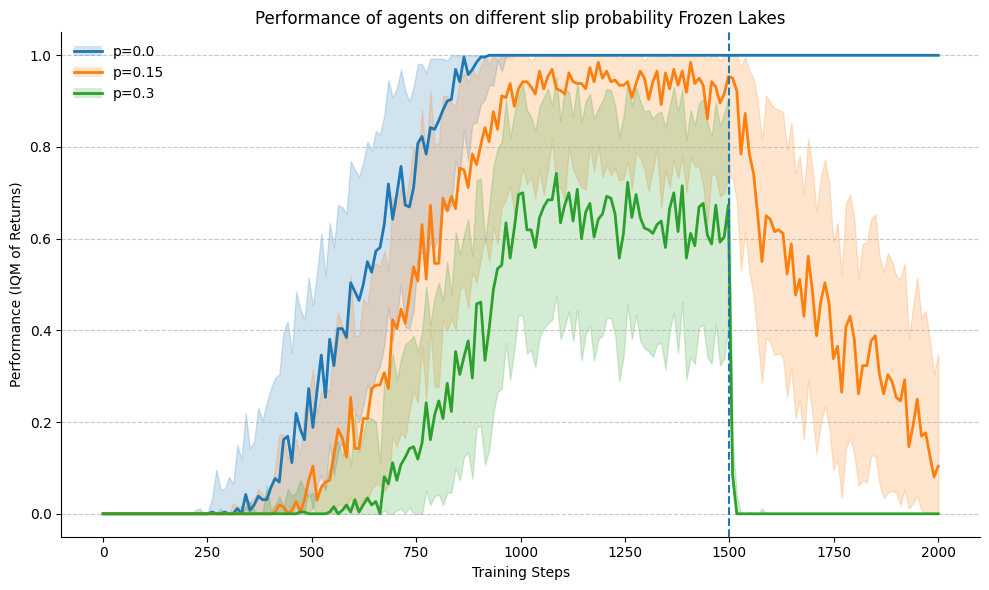

In [75]:
from matplotlib.legend_handler import HandlerTuple

fig, ax = plt.subplots(figsize=(10, 6))
legend_handles = []
legend_labels = []
metrics = {}

for ix, slip_prob in enumerate(SLIP_PROBS):
    exp_returns = np.array(all_returns[slip_prob])
    stats = get_robust_perf_stats(exp_returns, n_bootstrap_samples=2000, pbar=True)
    handle, label = plot_robust_perf_curve(
        ax, stats, label=f"p={slip_prob}", color=f"C{ix}", smooth=10
    )
    legend_handles.append(handle)
    legend_labels.append(label)

    metrics[slip_prob] = stats['iqm'][-100:].mean()

for slip_prob, asym_return in metrics.items():
    print(f'Slip prob: {slip_prob:.2f}, Last 100 eps IQM: {asym_return:0.3f}')


despine(ax)
ax.set_title("Performance of agents on different slip probability Frozen Lakes")
ax.set_xlabel("Training Steps")
ax.set_ylabel("Performance (IQM of Returns)")
ax.legend(
    legend_handles,
    legend_labels,
    handler_map={tuple: HandlerTuple(ndivide=1, pad=0)},
    frameon=False,
    loc="best",
)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.axvline(x=1_500, linestyle='--')
plt.tight_layout()
plt.show()

In [79]:
agent = agents[0.15]
agent.predictor.calib_set[0, 0]
np.vectorize(lambda x: len(x))(agent.predictor.calib_set)

array([[100, 100, 100, 100],
       [100, 100, 100, 100],
       [ 59,  55,  35,  35],
       [ 29,  11,  13,  18],
       [100, 100, 100, 100],
       [  0,   0,   0,   0],
       [ 10,  43,  15,  18],
       [  0,   0,   0,   0],
       [100, 100, 100, 100],
       [ 69, 100, 100,  61],
       [ 36, 100,  28,  33],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [ 45, 100, 100,  71],
       [100, 100, 100, 100],
       [  0,   0,   0,   0]])

In [97]:
ACTION_MAP = {
    'left': 0, 'down': 1, 'right': 2, 'up': 3
}

# # preds: np.ndarray, state: "State", action: "Action"
# state = 0
# action = ACTION_MAP['right']
# preds = agent.world_model[state, action]
# agent.predictor.conformalise(preds, state, action)
# # agent.predictor.conformalise(np.array([]), state=0, action=ACTION_MAP['right'])

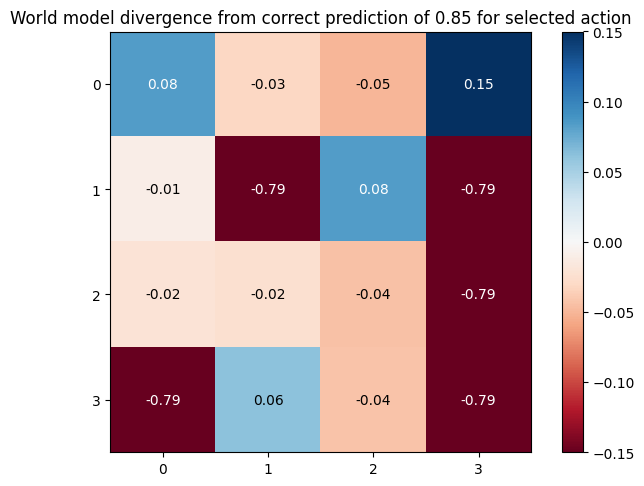

In [135]:
def plot_grid(vals: np.ndarray, vmin = None, vmax = None, cbar=True):
    vals_reshaped = vals.reshape((4, 4))

    fig, ax = plt.subplots()
    im = ax.imshow(vals_reshaped, cmap="RdBu", vmin=vmin, vmax=vmax)

    if cbar:
        plt.colorbar(im)
    # Put the value annotations back in
    for i in range(vals_reshaped.shape[0]):
        for j in range(vals_reshaped.shape[1]):
            ax.text(j, i,
                    f"{vals_reshaped[i, j]:.2f}",
                    ha="center", va="center",
                    color="white" if np.abs(vals_reshaped[i, j]) > np.median(np.abs(vals_reshaped)) else "black")

    # --- NEW: integer ticks 0-3 on both axes ---
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(4))
    ax.set_xticklabels(np.arange(4))
    ax.set_yticklabels(np.arange(4))

    plt.tight_layout()
    return fig

# In a calibrated world model the max for each state-action pair should
# be ,in principle, 0.85 - the true chance of not slipping
divergences_sa = agent.world_model.max(axis=2) - 0.85
divergences_sa = divergences_sa[range(16), np.abs(divergences_sa).argmax(axis=1)] # get the max divergence per state
fig = plot_grid(divergences_sa, vmin=-0.15, vmax=0.15)
plt.title(f'World model divergence from correct prediction of 0.85 for selected action')
plt.show()
# plot_grid(agent.V)

In [105]:
state = 4
action = ACTION_MAP['down']

preds = agent.world_model[state, action]
pred_set = agent.predictor.conformalise(preds, state, action)
pred_set

[4, 8]

In [6]:
returns = np.array(returns)
plt.plot(returns.reshape(-1, 100).mean(1))

NameError: name 'returns' is not defined

In [ ]:
# eval
agent.epsilon = 0.0

eval_returns = []
for episode in trange(1_000):
    done = False
    state, info = env.reset()
    while not done:
        action = agent.select_action(state)
        state_next, reward, terminated, truncated, info = env.step(action)
        state = state_next

        done = terminated or truncated
        if done:
            eval_returns.append(reward)

100%|██████████| 1000/1000 [00:00<00:00, 9108.37it/s]


In [ ]:
# plt.plot(eval_returns)
np.mean(eval_returns)

np.float64(0.718)

In [ ]:
agent.reward_model[-2]

array([0., 1., 0., 0.])